In [1]:
#Import the necessary Python moduless
import glob, os

import json 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import geopandas as gpd
from geopandas.tools import sjoin
import folium
from folium.plugins import MarkerCluster
from folium import IFrame
import shapely
from shapely.geometry import Point
import unicodedata
import pysal as ps


plt.rcParams["figure.figsize"] = (15,8)
pd.set_option('display.max_columns', None)

# 1. Data loading 

## 1.1 Load GIS data

In [2]:
import requests, zipfile, io

def get_shp_fnames(zip_file_url, data_dirr):
    """
    Get a list of names of shp files from a zip file at a zip_file_url
    Extract zip files a local directory defined by "data_dirr"
    e.g. zip_file_url = 'https://data.humdata.org/dataset/d2ec62bb-5a93-436d-8297-88b3ee9b6818
                        /resource/186a227b-6e9c-4b90-8634-b6369da07e17/download/mli_adm_1m_dnct_2019_shp.zip'
         data_dirr ='../data/GIS/'
          output:
          ['mli_admbnda_adm0_1m_dnct_20190802.shp',
           'mli_admbnda_adm1_1m_dnct_20190802.shp',
           'mli_admbnda_adm2_1m_dnct_20190802.shp',
           'mli_admbnda_adm3_1m_dnct_20190802.shp',
           'mli_admbndl_admALL_1m_dnct_itos_20190802.shp']
    """
    
    r = requests.get(zip_file_url, stream=True)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path=data_dirr)
    shp_fnames = [i for i in z.namelist() if i.endswith(".shp")]
    return shp_fnames

In [3]:
amd_zip_file_url = "https://data.humdata.org/dataset/d2ec62bb-5a93-436d-8297-88b3ee9b6818\
/resource/186a227b-6e9c-4b90-8634-b6369da07e17/download/mli_adm_1m_dnct_2019_shp.zip"
data_dirr = '../data/GIS/mli_adm_1m_dnct_2019_shp/'

adm_shp_fnames = get_shp_fnames(amd_zip_file_url, data_dirr)

In [4]:
adm_shp_fnames

['mli_admbnda_adm0_1m_dnct_20190802.shp',
 'mli_admbnda_adm1_1m_dnct_20190802.shp',
 'mli_admbnda_adm2_1m_dnct_20190802.shp',
 'mli_admbnda_adm3_1m_dnct_20190802.shp',
 'mli_admbndl_admALL_1m_dnct_itos_20190802.shp']

In [5]:
# read in shp files 
gis_adm0 = gpd.read_file(data_dirr+adm_shp_fnames[0])
gis_adm1 = gpd.read_file(data_dirr+adm_shp_fnames[1])
gis_adm2 = gpd.read_file(data_dirr+adm_shp_fnames[2])
gis_adm3 = gpd.read_file(data_dirr+adm_shp_fnames[3])

In [6]:
gis_adm1.ADM1_FR#.nunique()

0        Bamako
1           Gao
2         Kayes
3         Kidal
4     Koulikoro
5         Mopti
6         Ségou
7       Sikasso
8    Tombouctou
Name: ADM1_FR, dtype: object

## 1.2 Load population data

In [7]:
# download population data
def csv_from_url(url):
    """
    Read a csv file from an url into datafram format. Drop extra columns. 
    """
    df = pd.read_csv(url).dropna(axis =1, how='all').dropna(axis =0, how='all')
    return df

In [8]:
adm0_url = 'https://data.humdata.org/dataset/ce21c7db-d8f0-40f8-adc2-452d2d2d105c/resource/6f243ba2-4d4a-4663-a7c4-e917dbbde73a/download/mli_pop_adm0.csv'
adm1_url = 'https://data.humdata.org/dataset/ce21c7db-d8f0-40f8-adc2-452d2d2d105c/resource/0bd515ae-613c-400f-a84c-ea203cc529be/download/mli_pop_adm1.csv'
adm2_url = 'https://data.humdata.org/dataset/ce21c7db-d8f0-40f8-adc2-452d2d2d105c/resource/af0c935f-d507-4252-945c-9d1a6cc1b598/download/mli_pop_adm2.csv'
adm3_url = 'https://data.humdata.org/dataset/ce21c7db-d8f0-40f8-adc2-452d2d2d105c/resource/6a73b827-302d-47be-94a9-580fa73011b5/download/mli_pop_adm3.csv'

pop_adm0 = csv_from_url(adm0_url)
pop_adm1 = csv_from_url(adm1_url)
pop_adm2 = csv_from_url(adm2_url)
pop_adm3 = csv_from_url(adm3_url)

In [9]:
pop_adm3.shape

(701, 14)

## 1.3 Load health data

In [10]:
health_zip_file_url ="https://data.humdata.org/dataset/a512111d-9b60-4b8c-9b24-24a64da1506b/resource/b3074e99-2928-4f12-aeef-decd78b2c509/download/mali-shapefiles.zip"
data_dirr_h = '../data/GIS/mali-shapefiles/'
healthsite_shp_fnames =get_shp_fnames(health_zip_file_url,data_dirr_h)
gis_healthsites =gpd.read_file(data_dirr_h+healthsite_shp_fnames[0])

In [11]:
gis_healthsites.iloc[:3,20:]

,changese_1,emergency,changese_2,addr_house,addr_postc,addr_city,name,staff_nurs,changese_3,wheelchair,beds,url,dispensing,healthcare,operator_t,geometry
0,2,None,2014-11-19,None,None,None,Centre de Santé Communautaire de Banindo,None,jgc,yes,None,None,None,None,None,POINT (-6.84013 12.87360)
1,2,None,2018-07-03,None,None,None,SISSMED Santé,None,Nathalie SIDIBE,None,None,None,None,None,None,POINT (-8.03288 12.64399)
2,1,None,2020-11-18,None,None,None,centre de santé,None,MamaTraoré,None,None,None,None,hospital,None,POINT (-5.53963 13.09694)


## 1.4 Load settlement data

In [12]:
settlements_zip_file_url = 'https://data.humdata.org/dataset/1542b2e2-ffd1-4835-bc6f-a9e6dcf7421d/resource/bb63df0b-9485-4c88-90b6-3009e6fd072e/download/mli_populatedplaces_shp.zip'
data_dirr_settlement = '../data/GIS/mli_populatedplaces_shp/'
settlement_shp_fnames =get_shp_fnames(settlements_zip_file_url, data_dirr_settlement)
gis_settlement =gpd.read_file(data_dirr_settlement+settlement_shp_fnames[0])

In [13]:
gis_settlement.head(3)

,featureNam,pcode,featureRef,featureAlt,featureA_1,popPlaceCl,popPlace_1,admin0Name,admin0Pcod,admin1Name,admin1Pcod,admin2Name,admin2Pcod,admin3Name,admin3Pcod,date,validOn,validTo,geometry
0,Bambela,ML010101001,Bambela,None,None,5,None,Mali,ML,Kayes,ML01,Kayes,ML0101,Bangassi,ML010101,2015-02-02,2015-04-24,None,POINT (-11.57371 14.63110)
1,Bangassi-Doudou,ML010101002,Bangassi-Doudou,None,None,5,None,Mali,ML,Kayes,ML01,Kayes,ML0101,Bangassi,ML010101,2015-02-02,2015-04-24,None,POINT (-11.48828 14.53852)
2,Bangassi-Doudou-Maure,ML010101003,Bangassi-Doudou-Maure,None,None,5,None,Mali,ML,Kayes,ML01,Kayes,ML0101,Bangassi,ML010101,2015-02-02,2015-04-24,None,POINT (-11.48811 14.54539)


## 1.5 Load road data -- only has Bamako's data 

In [14]:
road_zip_file_url = 'https://data.humdata.org/dataset/f24cd828-1d81-427f-9f5a-c569f781b3a4/resource/bedfeb3e-0d82-41be-a394-fbe3688837d8/download/mali_bamako_road_network.zip'
data_dirr_road = '../data/GIS/Mali_Bamako_Road_Network/'
road_shp_fnames =get_shp_fnames(road_zip_file_url, data_dirr_road)
gis_road =gpd.read_file(data_dirr_road+road_shp_fnames[0])

In [15]:
gis_road.head(3)

,OBJECTID,nam,COMMENTS,SHAPE_STLe,geometry
0,1,Route de l'Aeroport,BAMAKO,0.061292,"LINESTRING Z (-7.94830 12.54048 0.00000, -7.94..."
1,2,UNK,BAMAKO,0.029022,"LINESTRING Z (-7.95113 12.54568 0.00000, -7.95..."
2,3,RN7,BAMAKO,0.089399,"LINESTRING Z (-7.91863 12.55985 0.00000, -7.91..."


## 1.6 Fews NET admin boundaries 

### This dataset is not as useful as it's updated 2001, and has less number of cercle compared to data in 1.1

In [16]:
fews_zip_file_url = 'https://fews.net/data_portal_download/download?data_file_path=http%3A//shapefiles.fews.net.s3.amazonaws.com/ADMIN/ML_Admin3_2001.zip'
data_dirr_FEWS = '../data/GIS/Mali_Admin_3_2001/'
FEWS_shp_fnames =get_shp_fnames(fews_zip_file_url, data_dirr_FEWS)

In [17]:
gis_FEWS =gpd.read_file(data_dirr_FEWS+FEWS_shp_fnames[0])

In [18]:
gis_FEWS.head(3)

,FNID,EFF_YEAR,COUNTRY,ADMIN0,ADMIN1,ADMIN1FR,ADMIN1SP,ADMIN1PT,ADMIN2,ADMIN2FR,ADMIN2SP,ADMIN2PT,ADMIN3,ADMIN3FR,ADMIN3SP,ADMIN3PT,ALIASES,geometry
0,ML2001A3080101,2001,ML,Mali,Kidal,Kidal,None,None,Kidal,Kidal,None,None,Anefif,Anefif,None,None,None,"POLYGON ((1.19692 17.70545, 1.17107 17.69898, ..."
1,ML2001A3080103,2001,ML,Mali,Kidal,Kidal,None,None,Kidal,Kidal,None,None,Kidal,Kidal,None,None,None,"POLYGON ((1.99160 18.05661, 1.96149 17.94038, ..."
2,ML2001A3080201,2001,ML,Mali,Kidal,Kidal,None,None,Tin-Essako,Tin-Essako,None,None,Tin-Essako,Tin-Essako,None,None,None,"POLYGON ((3.12732 19.11386, 3.14102 19.10392, ..."


In [19]:
gis_FEWS.ADMIN3FR.nunique()

679

## 1.7 Food crisis (World Bank microdata)

What the columnes means:https://microdata.worldbank.org/index.php/catalog/3811/data-dictionary/F1?file_name=predicting_food_crises_data

fews_ipc(https://fews.net/IPC, a way to measure famine): 
1: minimal
2: stressed
3: crisis
4: emergenecy
5: famine

fews_proj_near: FEWS Near-term projection (3 or 4 months ahead)
fews_proj_med: FEWS Medium-term projection (6 or 8 months ahead)
pop: UN-adjusted population count per year 

In [20]:
food_crisis_url = 'https://drive.google.com/file/d/1LfWAfl2nvvKX3ATYgfyUC-y-uaYsK006/view?usp=sharing'
food_crisis_url =  'https://drive.google.com/uc?export=download&id='+food_crisis_url.split('/')[-2]
fdc_df= csv_from_url(food_crisis_url)
# select only Mali
fdc_df = fdc_df[fdc_df.country =='Mali']

In [21]:
fdc_df.head(3)

,country,admin_code,admin_name,centx,centy,year_month,year,month,fews_ipc,fews_ha,fews_proj_near,fews_proj_near_ha,fews_proj_med,fews_proj_med_ha,ndvi_mean,ndvi_anom,rain_mean,rain_anom,et_mean,et_anom,acled_count,acled_fatalities,p_staple_food,area,cropland_pct,pop,ruggedness_mean,pasture_pct
68414,Mali,152,Bamako,-7.980037,12.60908,2007_01,2007,1,NaN,NaN,NaN,NaN,NaN,NaN,0.213914,99.01431,0.028291,-0.001200,0.740986,-0.277322,0,0,0.832460,246.0037,23.10941,1597043.0,103612.2,33.0
68415,Mali,152,Bamako,-7.980037,12.60908,2007_02,2007,2,NaN,NaN,NaN,NaN,NaN,NaN,0.200769,98.55176,0.029737,0.000202,0.495872,-0.035677,1,0,0.852214,246.0037,23.10941,1597043.0,103612.2,33.0
68416,Mali,152,Bamako,-7.980037,12.60908,2007_03,2007,3,NaN,NaN,NaN,NaN,NaN,NaN,0.184292,94.32494,0.369282,-0.095034,0.153154,-0.011573,0,0,0.841020,246.0037,23.10941,1597043.0,103612.2,33.0


In [22]:
fdc_df.describe()

,admin_code,centx,centy,year,month,fews_ipc,fews_ha,fews_proj_near,fews_proj_near_ha,fews_proj_med,fews_proj_med_ha,ndvi_mean,ndvi_anom,rain_mean,rain_anom,et_mean,et_anom,acled_count,acled_fatalities,p_staple_food,area,cropland_pct,pop,ruggedness_mean,pasture_pct
count,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,1950.000000,1400.000000,1550.000000,1500.000000,1550.000000,1500.000000,7900.000000,7900.000000,7900.000000,7900.000000,7865.000000,7865.000000,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7.900000e+03,7900.000000,7900.000000
mean,176.500000,-5.097522,14.531287,2013.088608,6.436709,1.164615,0.031429,1.159355,0.036667,1.141290,0.029333,0.288957,101.538996,8.367315,0.651420,4.046682,0.210085,0.428861,1.021013,1.075856,25110.965954,25.324647,3.351277e+05,24369.096940,57.111901
std,14.431783,3.601217,2.381438,3.799607,3.476056,0.422652,0.174535,0.409411,0.188005,0.396936,0.168795,0.157748,6.951415,13.395733,3.666544,6.939573,1.448372,1.471638,6.659483,0.161157,48617.956962,22.227517,3.382079e+05,23283.368359,26.127771
min,152.000000,-11.472250,10.635440,2007.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.091107,64.299860,0.000416,-17.151630,0.000000,-8.557343,0.000000,0.000000,0.553119,246.003700,0.003406,6.868174e+03,2338.966000,0.147493
25%,164.000000,-7.527299,12.934740,2010.000000,3.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.167040,97.668062,0.071951,-0.071490,0.214293,-0.144084,0.000000,0.000000,0.972703,6508.061000,7.383231,1.755360e+05,8057.319000,55.398940
50%,176.500000,-5.466938,14.141930,2013.000000,6.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.246732,101.246750,0.794871,-0.000063,0.822162,0.000000,0.000000,0.000000,1.076300,12003.155000,21.279980,2.469460e+05,14237.680000,63.764785
75%,189.000000,-3.326344,15.764470,2016.000000,9.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.376933,105.093225,12.087705,0.423949,3.762857,0.290592,0.000000,0.000000,1.187699,22860.610000,42.091600,3.767150e+05,36153.060000,75.460780
max,201.000000,3.141602,21.184900,2020.000000,12.000000,3.000000,1.000000,3.000000,1.000000,3.000000,1.000000,0.791602,146.956700,97.587210,55.520470,40.150040,9.051601,26.000000,186.000000,1.663530,331292.000000,90.036340,2.849272e+06,103612.200000,91.795450


## 1.8 Food Security 

In [101]:
food_sec_zip_url = "https://fdw.fews.net/api/ipcpackage/?country_code=ML&collection_date=2021-01-01"
data_dirr_fs = '../data/GIS/Mali_Food_Security/'
fs_shp_fnames =get_shp_fnames(food_sec_zip_url, data_dirr_fs)
fs_df_proj =gpd.read_file(data_dirr_fs+fs_shp_fnames[0]) # projected Feb to May 2021
fs_df_cur =gpd.read_file(data_dirr_fs+fs_shp_fnames[1]) # current Jan 2021

In [90]:
fs_shp_fnames

['ML_202101_ML2.shp', 'ML_202101_ML1.shp']

In [118]:
fs_df_cur.shape

(115, 13)

In [102]:
fs_df_proj.head(3)

,cov_start,cov_end,report_mon,country,ADMIN0,ADMIN1,ADMIN2,ADMIN3,LZCODE,LZNAME,ML2,HA2,geometry
0,02-2021,05-2021,01-2021,ML,Mali,Koulikoro,Banamba,None,ML13,Center-eastern Millet and Livestock,1,0,"POLYGON ((-6.75740 14.25557, -6.81527 14.26741..."
1,02-2021,05-2021,01-2021,ML,Mali,Kayes,Diema,None,ML13,Center-eastern Millet and Livestock,1,0,"MULTIPOLYGON (((-8.70068 14.95134, -8.69714 14..."
2,02-2021,05-2021,01-2021,ML,Mali,Mopti,Douentza,None,ML13,Center-eastern Millet and Livestock,2,0,"POLYGON ((-2.75070 15.43851, -2.72800 15.41476..."


In [104]:
fs_df_cur.head(3)

,cov_start,cov_end,report_mon,country,ADMIN0,ADMIN1,ADMIN2,ADMIN3,LZCODE,LZNAME,ML1,HA1,geometry
0,01-2021,01-2021,01-2021,ML,Mali,Koulikoro,Banamba,None,ML13,Center-eastern Millet and Livestock,1,0,"POLYGON ((-6.75740 14.25557, -6.81527 14.26741..."
1,01-2021,01-2021,01-2021,ML,Mali,Kayes,Diema,None,ML13,Center-eastern Millet and Livestock,1,0,"MULTIPOLYGON (((-8.70068 14.95134, -8.69714 14..."
2,01-2021,01-2021,01-2021,ML,Mali,Mopti,Douentza,None,ML13,Center-eastern Millet and Livestock,2,0,"POLYGON ((-2.75070 15.43851, -2.72800 15.41476..."


# 2. Clean & munge data

In [27]:
## data cleaning 

# rename the columns to make them align. using gis as the stardard 

name_dict = {'admin0Name_fr':'ADM0_FR', 'admin0Pcode':'ADM0_PCODE',
             'admin1Name_fr':'ADM1_FR', 'admin1Pcode':'ADM1_PCODE',
             'admin2Name_fr':'ADM2_FR', 'admin2Pcode':'ADM2_PCODE',
             'admin3Name_fr':'ADM3_FR', 'admin3Pcode':'ADM3_PCODE'}
pop_adm0.rename(columns = name_dict, inplace=True)
pop_adm1.rename(columns = name_dict, inplace=True)
pop_adm2.rename(columns = name_dict, inplace=True)
pop_adm3.rename(columns = name_dict, inplace=True)


In [28]:
# gis_adm3 have columns named differently. Rename the columns 
gis_name_dict = {'admin0Name':'ADM0_FR', 'admin0Pcod':'ADM0_PCODE',
             'admin1Name':'ADM1_FR', 'admin1Pcod':'ADM1_PCODE',
             'admin2Name':'ADM2_FR', 'admin2Pcod':'ADM2_PCODE',
             'admin3Name':'ADM3_FR', 'admin3Pcod':'ADM3_PCODE'}
gis_adm3.rename(columns =gis_name_dict ,inplace=True)

In [29]:
# merge population data with GIS data

adm0_cols_to_use = list(pop_adm0.columns.difference(gis_adm0.columns)) + ['ADM0_FR']
adm1_cols_to_use = list(pop_adm1.columns.difference(gis_adm1.columns)) + ['ADM1_PCODE']
adm2_cols_to_use = list(pop_adm2.columns.difference(gis_adm2.columns)) + ['ADM2_PCODE']
adm3_cols_to_use = list(pop_adm3.columns.difference(gis_adm3.columns)) + ['ADM3_PCODE']

adm0_df = gis_adm0.merge(pop_adm0[adm0_cols_to_use], on = 'ADM0_FR')
adm1_df = gis_adm1.merge(pop_adm1[adm1_cols_to_use], on = 'ADM1_PCODE')
adm2_df = gis_adm2.merge(pop_adm2[adm2_cols_to_use], on = 'ADM2_PCODE')
adm3_df = gis_adm3.merge(pop_adm3[adm3_cols_to_use], on = 'ADM3_PCODE')

In [30]:
# join on to latest food crisis data
fdc_df_202002 = fdc_df.groupby(['admin_name']).last().reset_index()[['admin_name','fews_ipc','fews_ha','fews_proj_near','fews_proj_med','pop' ]]
fdc_df_202002 = fdc_df_202002.rename(columns = {'admin_name': 'ADM1_FR'})
adm3_df = adm3_df.merge(fdc_df_202002, on = 'ADM1_FR', how ='outer')

## 3. Plotting

### 3.1 Geopandas

<IPython.core.display.Javascript object>


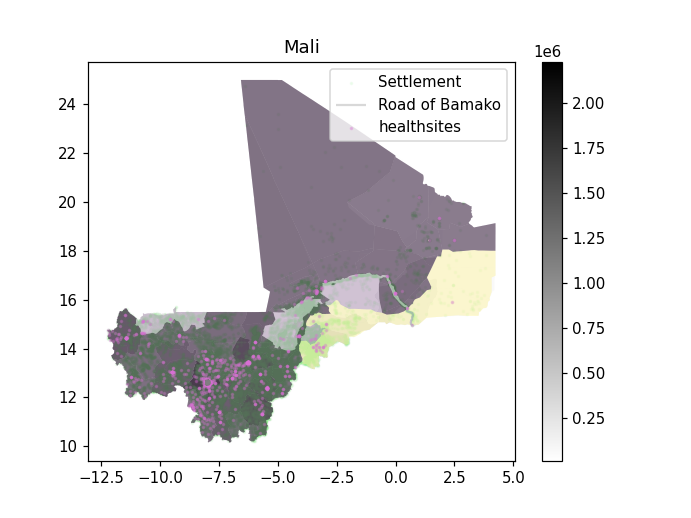

Text(0.5, 1.0, 'Mali')

In [125]:
%matplotlib notebook
base = adm2_df.plot(column='Ensemble',legend=True, cmap='binary')#, scheme='quantiles')
gis_settlement.plot(color='lightgreen',markersize=2, ax =base, alpha = 0.1)
# Jan 2021 food stress (yellow)
fs_df_cur.plot(ax =base, column='ML1',alpha = 0.3)
# Projected food stress Feb to May 2021 (pale)
fs_df_proj.plot(ax =base, column='ML2',alpha = 0.3, cmap = 'afmhot')
gis_road.plot(color='grey',markersize=2, ax =base, alpha = 0.3)
gis_healthsites.plot(color='orchid',markersize=2,ax =base, alpha = 0.3)
plt.legend(['Settlement','Road of Bamako','healthsites'])
plt.title('Mali')

### 3.2 Folium

In [110]:
# convert to geojson 
adm1_gj = json.loads(adm1_df.to_crs(epsg='4326').to_json())
adm2_gj = json.loads(adm2_df.to_crs(epsg='4326').to_json())
adm3_gj = json.loads(adm3_df.to_crs(epsg='4326').to_json())

In [139]:
m = folium.Map(location=[17.89305884201745, -1.7063720462619767], zoom_start=5)
adm1_geojson = folium.features.GeoJson(adm1_gj)
adm2_geojson = folium.features.GeoJson(adm2_gj)
adm3_geojson = folium.features.GeoJson(adm3_gj)
#m.add_child(adm1_geojson)
m.add_child(adm2_geojson)
#m.add_child(adm3_geojson)

# add population information 
choropleth = folium.Choropleth(adm2_gj,
                  fill_color='yellow',
                  fill_opacity=0.2,
                  line_opacity=0,
                  legend_name='population',
).add_to(m)

# display population when hover the mouse over
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['ADM2_FR','Ensemble','Féminin','Masculin'])
)

m